# Preprocess the TLC Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
spark = (
    SparkSession.builder.appName("preprocess")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "3g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

In [3]:
sdf_2019 = spark.read.parquet('../data/raw/yellow_taxi_data_2019/')

# Preliminary data analysis

In [4]:
print(f'total of {sdf_2019.count():,} rows')

total of 84,598,444 rows


In [5]:
sdf_2019.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [6]:
# Check the statistics for numeric attributes
sdf_2019.describe(['tip_amount', 'trip_distance', 'passenger_count', 'fare_amount']).show()

+-------+------------------+------------------+------------------+------------------+
|summary|        tip_amount|     trip_distance|   passenger_count|       fare_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|          84598444|          84598444|          84154061|          84598444|
|   mean| 2.190078737505638|3.0183506184817515|1.5626654190817957|13.412639732835764|
| stddev|15.638996154306168| 8.093902044464816|1.2079081585219809|174.17668755385404|
|    min|            -221.0|         -37264.53|               0.0|           -1856.0|
|    max|         141492.02|          45977.22|               9.0|          943274.8|
+-------+------------------+------------------+------------------+------------------+



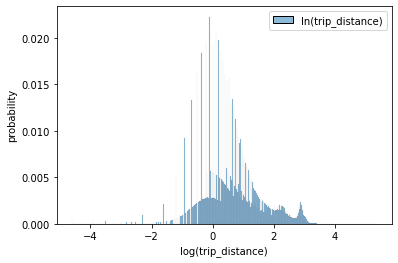

In [7]:
# It seems like trip_distance approximately follow a log-normal distribution
log_trip_distance = sdf_2019.filter(F.col('trip_distance') > 0).select(F.log(F.col('trip_distance')))
df = log_trip_distance.sample(0.05, seed=0).toPandas()
hist = sns.histplot(data = df, stat = 'probability')
hist.set(xlabel='log(trip_distance)', ylabel='probability')
plt.show()

In [8]:
# we will treat data that is 3 std away from mean as outlier
stat = log_trip_distance.select(F.mean('ln(trip_distance)').alias('mean'), 
                                F.stddev('ln(trip_distance)').alias('std')).collect()

td_lower, td_upper = math.exp(stat[0]['mean'] - 3*stat[0]['std']), math.exp(stat[0]['mean'] + 3*stat[0]['std'])
td_lower, td_upper

(0.10780246363537173, 31.786485869296914)

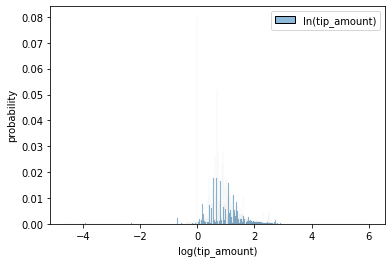

In [9]:
# It seems like trip_amount also approximately follow a log-normal distribution
log_tip_amount = sdf_2019.filter(F.col('tip_amount') > 0).select(F.log(F.col('tip_amount')))
df = log_tip_amount.sample(0.05, seed=0).toPandas()
hist = sns.histplot(data = df, stat = 'probability')
hist.set(xlabel='log(tip_amount)', ylabel='probability')
plt.show()

In [10]:
# we will treat data that is 3 std away from mean as outlier
stat = log_tip_amount.select(F.mean('ln(tip_amount)').alias('mean'), 
                                F.stddev('ln(tip_amount)').alias('std')).collect()

ta_lower, ta_upper = math.exp(stat[0]['mean'] - 3*stat[0]['std']), math.exp(stat[0]['mean'] + 3*stat[0]['std'])
ta_lower, ta_upper

(0.345501105744151, 18.46019783041283)

In [11]:
# Check null value
for column in sdf_2019.columns:
    print(f'{column} has {sdf_2019.where(F.col(column).isNull()).count()} null value(s)')

VendorID has 0 null value(s)
tpep_pickup_datetime has 0 null value(s)
tpep_dropoff_datetime has 0 null value(s)
passenger_count has 444383 null value(s)
trip_distance has 0 null value(s)
RatecodeID has 444383 null value(s)
store_and_fwd_flag has 444383 null value(s)
PULocationID has 0 null value(s)
DOLocationID has 0 null value(s)
payment_type has 0 null value(s)
fare_amount has 0 null value(s)
extra has 0 null value(s)
mta_tax has 0 null value(s)
tip_amount has 0 null value(s)
tolls_amount has 0 null value(s)
improvement_surcharge has 0 null value(s)
total_amount has 0 null value(s)
congestion_surcharge has 5300601 null value(s)
airport_fee has 84598444 null value(s)


In [12]:
# line 23~31: Drop the attributes that we are not interested in
# line 32: Drop the rows with null passenger_count and RatecodeID
# line 33~34: Remove data not in 2019
# line 35: A reasonable tip amount is between 0.3455 and 18.4602
# line 36: A reasonable trip distance is between 0.1078 and 31.7865 miles
# line 37: A reasonable fare amount is between $2.5(initial charge) and $1000
# line 38: RateCodeID should be one of the integer in the range of 1-6
# line 39: Only trips paid by credit card or cash are included
# line 40: Passenger count must not be zero
# line 41~42: Zone 264, 265 are unknown zone
# line 43~46: Extract the pick-up month, day and hour
# line 47: Extract the drop-off hour
# line 48: trip_distance in kilometres
# line 49~50: duaration of trips
# line 51: trip distance must be greater than 500m
# line 52: trip duration must be greater than 3 min

def transform(sdf, year):
    """
    return a modified sdf
    """
    sdf_mdf = sdf \
            .drop('VendorID', 
                  'store_and_fwd_flag', 
                  'extra',
                  'mta_tax',
                  'improvement_surcharge',
                  'tolls_amount', 
                  'total_amount',
                  'congestion_surcharge',
                  'airport_fee') \
            .dropna(how='any') \
            .filter((F.year('tpep_pickup_datetime') == year) & 
                    (F.year('tpep_dropoff_datetime') == year) == True) \
            .filter((F.col('tip_amount') >= ta_lower) & (F.col('tip_amount') < ta_upper)) \
            .filter((F.col('trip_distance') > td_lower) & (F.col('trip_distance') < td_upper)) \
            .filter((F.col('fare_amount') > 2.5) & (F.col('fare_amount') < 1000)) \
            .filter(F.col('RatecodeID').isin(list(range(1, 7)))) \
            .filter(F.col('payment_type').isin(1, 2)) \
            .filter(F.col('passenger_count') != 0) \
            .filter((F.col('PULocationID').isin([264, 265]) == False) & 
                    (F.col('DOLocationID').isin([264, 265]) == False)) \
            .withColumn('PUMonth', F.month(F.col('tpep_pickup_datetime'))) \
            .withColumn('PUDay', F.dayofmonth(F.col('tpep_pickup_datetime'))) \
            .withColumn('PUDayofweek', (F.dayofweek(F.col('tpep_pickup_datetime'))+5)%7+1) \
            .withColumn('PUHour', F.hour(F.col('tpep_pickup_datetime'))) \
            .withColumn('DOHour', F.hour(F.col('tpep_dropoff_datetime'))) \
            .withColumn('trip_distance(km)', F.col('trip_distance') * 1.60934) \
            .withColumn('time_difference(s)', F.col('tpep_dropoff_datetime').cast('long') - \
                                                F.col('tpep_pickup_datetime').cast('long')) \
            .filter(F.col('trip_distance(km)') > 0.5) \
            .filter(F.col('time_difference(s)') / 60 > 3) \
    
    return sdf_mdf


new_sdf_2019 = transform(sdf_2019, 2019)

In [13]:
aggregated_result = new_sdf_2019 \
                     .groupBy("PULocationID",
                              "DOLocationID",
                              "PUMonth",
                              "PUDay",
                              "PUDayofweek",
                              "PUHour",
                              "DOHour"
                             ) \
                     .agg(
                       F.count('PULocationID').alias("trip_count"),
                     )
                    

aggregated_result.show()

+------------+------------+-------+-----+-----------+------+------+----------+
|PULocationID|DOLocationID|PUMonth|PUDay|PUDayofweek|PUHour|DOHour|trip_count|
+------------+------------+-------+-----+-----------+------+------+----------+
|         132|         249|      3|    1|          5|     0|     1|         1|
|          68|         234|      3|    1|          5|     0|     0|         4|
|         148|          87|      3|    1|          5|     0|     0|         5|
|         132|         234|      3|    1|          5|     0|     0|         2|
|         142|         236|      3|    1|          5|     0|     0|         2|
|          48|         181|      3|    1|          5|     0|     0|         1|
|         249|          52|      3|    1|          5|     0|     1|         1|
|         162|         230|      3|    1|          5|     0|     0|         2|
|          88|          18|      3|    1|          5|     0|     0|         1|
|         249|          61|      3|    1|          5

In [14]:
# write out the aggregated results
aggregated_result.write.mode('overwrite').parquet('../data/curated/aggregated_result_2019')

# Subsampling

In [15]:
# Also the same procedure will be applied to 2020 data
sdf_2020 = spark.read.parquet('../data/raw/yellow_taxi_data_2020/')
new_sdf_2020 = transform(sdf_2020, 2020)

In [16]:
# Due to lockdown of NYC in March, 2020, the records has declined substantially
# I will use data from January to February to validate model predictions
reduced_sdf = new_sdf_2020.filter(F.col("PUMonth").isin([1, 2]))
aggregated_result = reduced_sdf \
                     .groupBy("PULocationID",
                              "DOLocationID",
                              "PUMonth",
                              "PUDay",
                              "PUDayofweek",
                              "PUHour"
                             ) \
                     .agg(
                       F.count('PULocationID').alias("trip_count"),
                     )  
reduced_sdf.write.mode('overwrite').parquet("../data/curated/aggregated_result_2020")